Shooting Value
==============

* Sh/90 - 0.5
* npxG/90 - 0.5


Passing Value
=============

* xAG - 0.2
* xA - 0.2
* KP - 0.175
* PPA - 0.175
* 1/3 - 0.125
* PrgP - 0.125


Dribble Value
=============

* Att Pen - 0.235
* SuccDri - 0.118
* PrgC - 0.176
* 1/3 - 0.118
* CPA - 0.176
* Mis + Dis (inverse) - 0.059
* Fld 0.118


In [15]:
import pandas as pd

def clean_dataframe(df):
    # Remove rows where Player column contains 'Player' (these are repeated headers)
    df = df[df[('Unnamed: 1_level_0', 'Player')] != 'Player']
    return df

def scrape_metrics(min_90s=6):
    # Possession data
    df_possession = pd.read_html("https://fbref.com/en/comps/Big5/possession/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_possession"})[0]
    
    df = df_possession[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Unnamed: 3_level_0', 'Pos'),
        ('Unnamed: 8_level_0', '90s'),
        ('Carries', 'CPA'),
        ('Carries', 'Dis'),
        ('Touches', 'Att Pen'),
        ('Carries', 'Mis'),
        ('Take-Ons', 'Succ'),
        ('Carries', '1/3'),
        ('Carries', 'PrgC')
    ]]
    
    # Clean the dataframe to remove repeated headers
    df = clean_dataframe(df)
    
    # Create unique identifier
    df['player_id'] = df[('Unnamed: 1_level_0', 'Player')] + ' - ' + df[('Unnamed: 4_level_0', 'Squad')]

    # Misc data
    df_misc = pd.read_html("https://fbref.com/en/comps/Big5/misc/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_misc"})[0]
    df_misc = df_misc[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Performance', 'Fld')
    ]]
    df_misc = clean_dataframe(df_misc)
    df_misc['player_id'] = df_misc[('Unnamed: 1_level_0', 'Player')] + ' - ' + df_misc[('Unnamed: 4_level_0', 'Squad')]

    # First merge
    df = pd.merge(
        df,
        df_misc.drop([('Unnamed: 1_level_0', 'Player'), ('Unnamed: 4_level_0', 'Squad')], axis=1),
        on='player_id',
        how='left'
    )

    # Passing data
    df_passing = pd.read_html("https://fbref.com/en/comps/Big5/passing/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_passing"})[0]

    df_pass_cmp = df_passing[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Unnamed: 29_level_0', 'PPA'),
        ('Unnamed: 28_level_0', '1/3'),
        ('Unnamed: 31_level_0', 'PrgP'),
        ('Unnamed: 27_level_0', 'KP'),
        ('Unnamed: 24_level_0', 'xAG'),
        ('Expected', 'xA'),
    ]]
    df_pass_cmp = clean_dataframe(df_pass_cmp)
    df_pass_cmp['player_id'] = df_pass_cmp[('Unnamed: 1_level_0', 'Player')] + ' - ' + df_pass_cmp[('Unnamed: 4_level_0', 'Squad')]

    # Second merge
    df = pd.merge(
        df,
        df_pass_cmp.drop([('Unnamed: 1_level_0', 'Player'), ('Unnamed: 4_level_0', 'Squad')], axis=1),
        on='player_id',
        how='left'
    )

    # Shooting data
    df_shooting = pd.read_html("https://fbref.com/en/comps/Big5/shooting/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_shooting"})[0]
    df_shooting = df_shooting[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Expected', 'npxG'),
        ('Standard', 'Sh')
    ]]
    df_shooting = clean_dataframe(df_shooting)
    df_shooting['player_id'] = df_shooting[('Unnamed: 1_level_0', 'Player')] + ' - ' + df_shooting[('Unnamed: 4_level_0', 'Squad')]

    # Third merge
    df = pd.merge(
        df,
        df_shooting.drop([('Unnamed: 1_level_0', 'Player'), ('Unnamed: 4_level_0', 'Squad')], axis=1),
        on='player_id',
        how='left'
    )

    # SCA data
    df_gca = pd.read_html("https://fbref.com/en/comps/Big5/gca/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_gca"})[0]
    df_gca = df_gca[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('SCA Types', 'TO')
    ]]
    df_gca = clean_dataframe(df_gca)
    df_gca['player_id'] = df_gca[('Unnamed: 1_level_0', 'Player')] + ' - ' + df_gca[('Unnamed: 4_level_0', 'Squad')]


    # 4th merge
    df = pd.merge(
        df,
        df_gca.drop([('Unnamed: 1_level_0', 'Player'), ('Unnamed: 4_level_0', 'Squad')], axis=1),
        on='player_id',
        how='left'
    )

    # Drop the temporary player_id column
    df = df.drop('player_id', axis=1)

    # Rename columns
    df.columns = [
        "player", "team", "position", "90s",
        "carries_pa", "dispossessed", "touches_pa", "miscontrols", "succ_takeons", "carries_final_third", "prog_carries",
        "fouls_drawn",
        "passes_pa", "passes_final_third", "prog_passes", "key_passes", "xAG", "xA",
        "npxG", 'shots',
        "takeons_lead_to_shot"
    ]

    # Convert to numeric and adjust metrics
    df['90s'] = pd.to_numeric(df['90s'], errors='coerce')
    
    metrics_to_adjust = [
        'carries_pa', 'dispossessed', 'touches_pa', "miscontrols", "succ_takeons", "carries_final_third", "prog_carries",
        'fouls_drawn',
        "passes_pa", "passes_final_third", "prog_passes", "key_passes", "xAG", "xA",
        'npxG', 'shots',
        "takeons_lead_to_shot"
    ]
    
    for metric in metrics_to_adjust:
        df[metric] = pd.to_numeric(df[metric], errors='coerce')
        df[metric] = df[metric] / df['90s']

    df["carry_losses"] =  df["miscontrols"] + df["dispossessed"]

    df = df.drop(["miscontrols", "dispossessed"], axis=1)

    # Filter conditions
    df = df[df['90s'] > min_90s]
    df = df[df['position'].str.contains('FW')]

    return df

# Try running with the cleaned data
#df = scrape_metrics(min_90s=8)
#df.to_csv("jan25_player_data_8_90s.csv", index=False)

df = pd.read_csv("jan25_player_data_8_90s.csv")
print(df.head(20))

                            player             team position   90s  \
0                    Himad Abdelli           Angers    MF,FW  17.7   
1                   Matthis Abline           Nantes       FW  15.6   
2                Zakaria Aboukhlal         Toulouse    MF,FW  15.8   
3                       Akor Adams      Montpellier       FW  11.9   
4                        Che Adams           Torino       FW  14.8   
5                     Junior Adamu         Freiburg       FW  10.1   
6                 Oladapo Afolayan        St. Pauli    FW,MF  13.3   
7                  Ludovic Ajorque            Brest       FW  13.5   
8                Maghnes Akliouche           Monaco    FW,MF  12.3   
9                  Mohamed Ali Cho             Nice    FW,MF   9.8   
10                   Jim Allevinah           Angers       FW  10.5   
11  Domingos André Ribeiro Almeida         Valencia    MF,FW  10.3   
12                  Adrià Altimira          Leganés    DF,FW   8.6   
13                  

In [16]:
def calculate_triple_threat(df, additional_players=None):
    """
    Calculate triple threat scores for players.
    
    Parameters:
    df (pd.DataFrame): Original dataframe with player statistics
    additional_players (pd.DataFrame, optional): Additional players to include in analysis
    
    Returns:
    pd.DataFrame: DataFrame with triple threat scores
    """
    # Make a copy of the input DataFrame
    if additional_players is not None:
        df = pd.concat([df, additional_players], ignore_index=True).copy()
    else:
        df = df.copy()
    
    # List of metrics to calculate percentiles for
    metrics = [
        'touches_pa', 'succ_takeons', 'carries_final_third', 'carries_pa', 'prog_carries', "takeons_lead_to_shot",
        'fouls_drawn', 'passes_pa', 'passes_final_third', 'prog_passes', 'key_passes',
        'xAG', 'xA', 'npxG', 'shots'
    ]

    # Calculate percentiles for regular metrics (higher is better)
    for metric in metrics:
        percentile_col = f"{metric}_percentile"
        df.loc[:, percentile_col] = df[metric].rank(pct=True) * 100

    # Calculate percentile for carry_losses (lower is better, so invert)
    df.loc[:, 'carry_losses_percentile'] = (1 - df['carry_losses'].rank(pct=True)) * 100

    # Create result DataFrame with all columns we'll need
    result_columns = ['player', 'team', 'shooting_score', 'carrying_score', 'passing_score', 'triple_threat_score']
    df_triple_threat = pd.DataFrame(columns=result_columns)
    
    # Copy player and team columns
    df_triple_threat['player'] = df['player']
    df_triple_threat['team'] = df['team']

    # Calculate shooting score
    df_triple_threat.loc[:, 'shooting_score'] = (
        df['npxG_percentile'] * 0.5 + 
        df['shots_percentile'] * 0.5
    )

    # Calculate carrying score
    df_triple_threat.loc[:, 'carrying_score'] = (
        df['touches_pa_percentile'] * 0.211 +
        df['succ_takeons_percentile'] * 0.106 +
        df['carries_final_third_percentile'] * 0.106 +
        df['fouls_drawn_percentile'] * 0.106 +
        df['carries_pa_percentile'] * 0.158 +
        df['carry_losses_percentile'] * 0.053 +
        df['prog_carries_percentile'] * 0.158 +
        df["takeons_lead_to_shot_percentile"] * 0.102
        )

    # Calculate passing score
    df_triple_threat.loc[:, 'passing_score'] = (
        df['passes_pa_percentile'] * 0.175 +
        df['passes_final_third_percentile'] * 0.125 +
        df['prog_passes_percentile'] * 0.125 +
        df['key_passes_percentile'] * 0.175 +
        df['xAG_percentile'] * 0.2 +
        df['xA_percentile'] * 0.2
    )

    # Calculate triple threat score
    df_triple_threat.loc[:, 'triple_threat_score'] = (
        df_triple_threat['shooting_score'] +
        df_triple_threat['carrying_score'] +
        df_triple_threat['passing_score']
    ) / 3

    return df_triple_threat.sort_values(by='triple_threat_score', ascending=False)

df_triple_threat = calculate_triple_threat(df)
df_triple_threat.head(20)

,player,team,shooting_score,carrying_score,passing_score,triple_threat_score
78,Ousmane Dembélé,Paris S-G,97.368421,84.77313,99.127424,93.756325
245,Michael Olise,Bayern Munich,81.786704,88.741274,98.303324,89.610434
350,Lamine Yamal,Barcelona,86.565097,89.809141,91.966759,89.446999
272,Raphinha,Barcelona,94.598338,77.314681,94.671053,88.861357
205,Omar Marmoush,Eint Frankfurt,95.290859,89.552632,80.193906,88.345799
167,Vinicius Júnior,Real Madrid,83.795014,94.198338,83.725762,87.239705
65,Kingsley Coman,Bayern Munich,87.950139,83.468421,90.294321,87.237627
286,Mohamed Salah,Liverpool,96.398892,77.770222,86.814404,86.994506
195,Ademola Lookman,Atalanta,93.628809,83.175623,79.68144,85.495291
211,Kylian Mbappé,Real Madrid,96.814404,83.653463,74.387119,84.951662


In [17]:
new_players = pd.DataFrame([
    {
        'player': 'Mo Salah (19/20)',
        'team': 'Liverpool',
        'touches_pa': 9.09,
        'succ_takeons': 1.56,
        'carries_final_third': 1.59,
        'carries_pa': 2.25,
        'prog_carries': 3.28,
        'fouls_drawn': 0.56,
        'passes_pa': 1.78,
        'passes_final_third': 1.28,
        'prog_passes': 2.84,
        'key_passes': 1.88,
        'xAG': 0.24,
        'xA': 0.22,
        'npxG': 0.52,
        'shots': 4.03,
        'carry_losses': 4.84
    },
        {
        'player': 'Roberto Firmino (19/20)',
        'team': 'Liverpool',
        'touches_pa': 6.59,
        'succ_takeons': 1.57,
        'carries_final_third': 1.87,
        'carries_pa': 1.05,
        'prog_carries': 2.71,
        'fouls_drawn': 0.48,
        'passes_pa': 0.93,
        'passes_final_third': 2.23,
        'prog_passes': 3.34,
        'key_passes': 1.57,
        'xAG': 0.20,
        'xA': 0.12,
        'npxG': 0.42,
        'shots': 2.98,
        'carry_losses': 3.94
    },
        {
        'player': 'Sadio Mane (19/20)',
        'team': 'Liverpool',
        'touches_pa': 6.36,
        'succ_takeons': 2.26,
        'carries_final_third': 3.38,
        'carries_pa': 2.03,
        'prog_carries': 5.21,
        'fouls_drawn': 1.67,
        'passes_pa': 2.36,
        'passes_final_third': 2.20,
        'prog_passes': 4.20,
        'key_passes': 1.93,
        'xAG': 0.22,
        'xA': 0.17,
        'npxG': 0.43,
        'shots': 2.52,
        'carry_losses': 5.15
    }
])

results_with_new = calculate_triple_threat(df, new_players)

# Filter to show only the new players we added
new_player_names = new_players['player'].tolist()
new_player_results = results_with_new[results_with_new['player'].isin(new_player_names)]

# Display results with rounded scores
new_player_results

,player,team,shooting_score,carrying_score,passing_score,triple_threat_score
361,Mo Salah (19/20),Liverpool,95.879121,NaN,73.447802,NaN
362,Roberto Firmino (19/20),Liverpool,85.989011,NaN,61.174451,NaN
363,Sadio Mane (19/20),Liverpool,79.945055,NaN,78.791209,NaN


In [18]:
def print_component_rankings(df_results, component, n=5):
    print(f"\nTop {n} Players by {component.title()} Score:")
    print(df_results.sort_values(by=f"{component}_score", ascending=False).head(n))
    return df_results.sort_values(by=f"{component}_score", ascending=False).head(n)

# Example component analysis
top_shooters = print_component_rankings(results_with_new, "shooting")
top_carriers = print_component_rankings(results_with_new, "carrying")
top_passers = print_component_rankings(results_with_new, "passing")


Top 5 Players by Shooting Score:
                player             team shooting_score carrying_score  \
330        Deniz Undav        Stuttgart      99.862637      39.835874   
274      Mateo Retegui         Atalanta      98.076923      33.680974   
317  Alexander Sørloth  Atlético Madrid      97.664835      49.625372   
139     Erling Haaland  Manchester City      97.664835      43.762382   
78     Ousmane Dembélé        Paris S-G       97.39011      84.762274   

    passing_score triple_threat_score  
330     46.074863           61.924458  
274     29.168956           53.642284  
317     33.090659           60.126956  
139     11.823489           51.083569  
78      99.134615           93.762333  

Top 5 Players by Carrying Score:
              player             team shooting_score carrying_score  \
167  Vinicius Júnior      Real Madrid      83.379121      94.172229   
88       Jeremy Doku  Manchester City      26.510989      91.181261   
189      Rafael Leão            Milan   

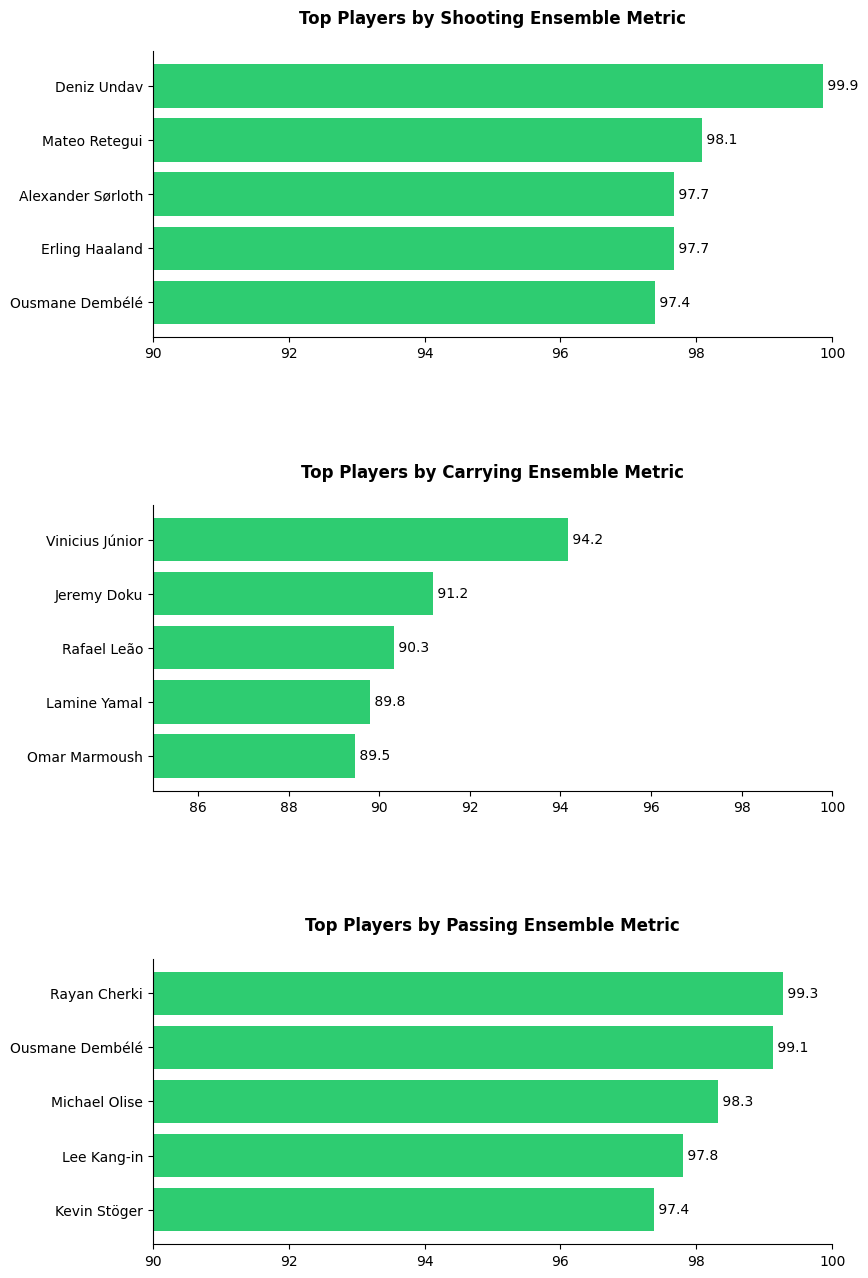

In [19]:
import matplotlib.pyplot as plt

def plot_top_players(data_list, metric_cols, titles, low_lims):
    
    # Create figure with 3 subplots vertically stacked
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    fig.tight_layout(pad=10.0)  # Add space between subplots
    
    for i, (data, metric_col, title, low_lim) in enumerate(zip(data_list, metric_cols, titles, low_lims)):
        ax = axes[i]
        
        # Create horizontal bar plot
        ax.barh(data["player"], data[metric_col], color='#2ecc71')
        ax.invert_yaxis()
        ax.set_xlim(low_lim, 100)
        
        # Add value labels
        for j, v in enumerate(data[metric_col]):
            ax.text(v, j, f' {v:.1f}', va='center')
        
        # Remove borders
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add title
        ax.set_title(title, fontdict={"weight": "bold"}, pad=20)

    plt.show()

# Create single figure with all three plots
plot_top_players(
    data_list=[top_shooters, top_carriers, top_passers],
    metric_cols=["shooting_score", "carrying_score", "passing_score"],
    titles=["Top Players by Shooting Ensemble Metric",
           "Top Players by Carrying Ensemble Metric",
           "Top Players by Passing Ensemble Metric"],
    low_lims=[90, 85, 90]
)


Top 5 Players by Triple_Threat Score:
              player            team shooting_score carrying_score  \
78   Ousmane Dembélé       Paris S-G       97.39011      84.762274   
245    Michael Olise   Bayern Munich      81.387363      88.495934   
350     Lamine Yamal       Barcelona      86.126374      89.789388   
272         Raphinha       Barcelona      94.505495      77.077563   
205    Omar Marmoush  Eint Frankfurt      95.192308      89.461999   

    passing_score triple_threat_score  
78      99.134615           93.762333  
245     98.317308           89.400201  
350     92.032967           89.316243  
272     94.666896           88.749984  
205     80.123626           88.259311  


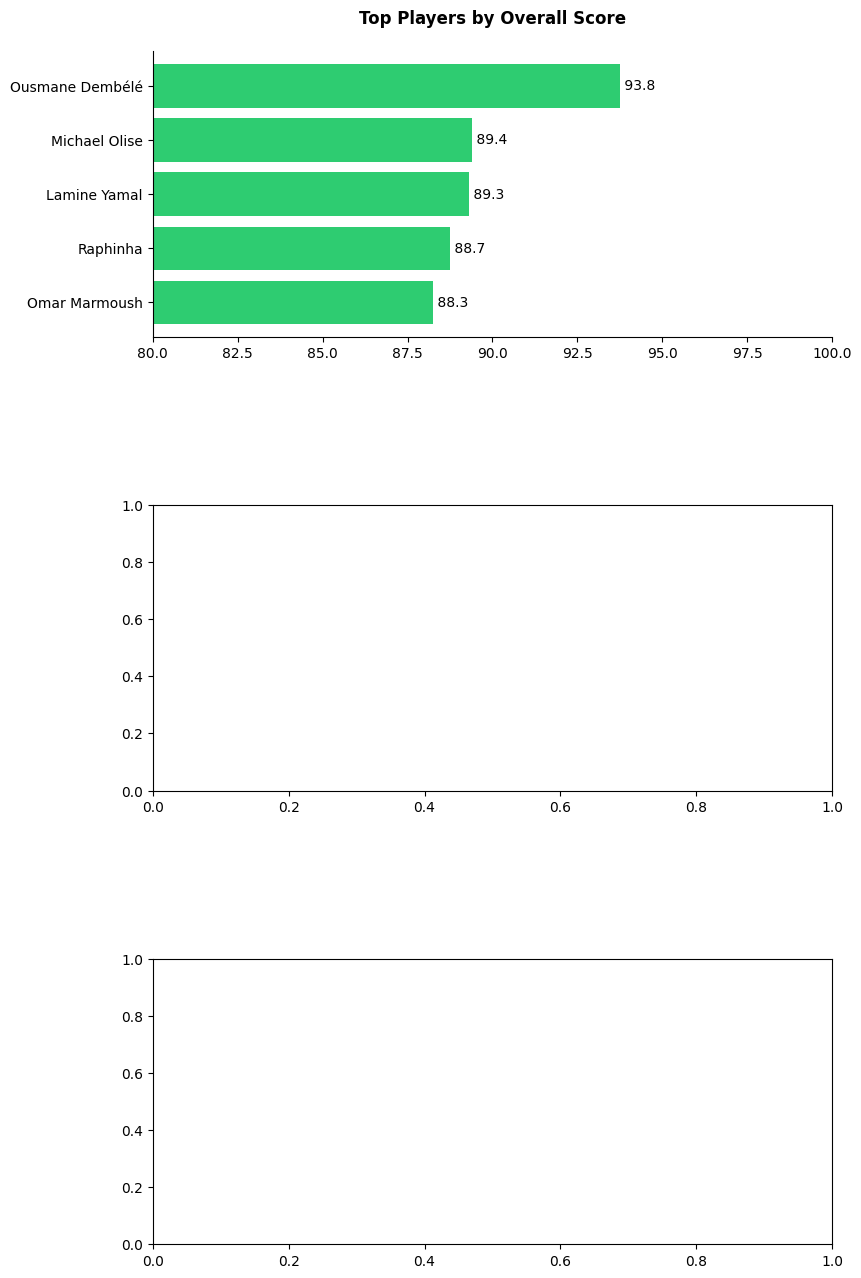

In [20]:
top_triplers = print_component_rankings(results_with_new, "triple_threat")
plot_top_players(data_list=[top_triplers],
                 metric_cols=["triple_threat_score"],
                 titles=["Top Players by Overall Score"],
                 low_lims=[80]
)

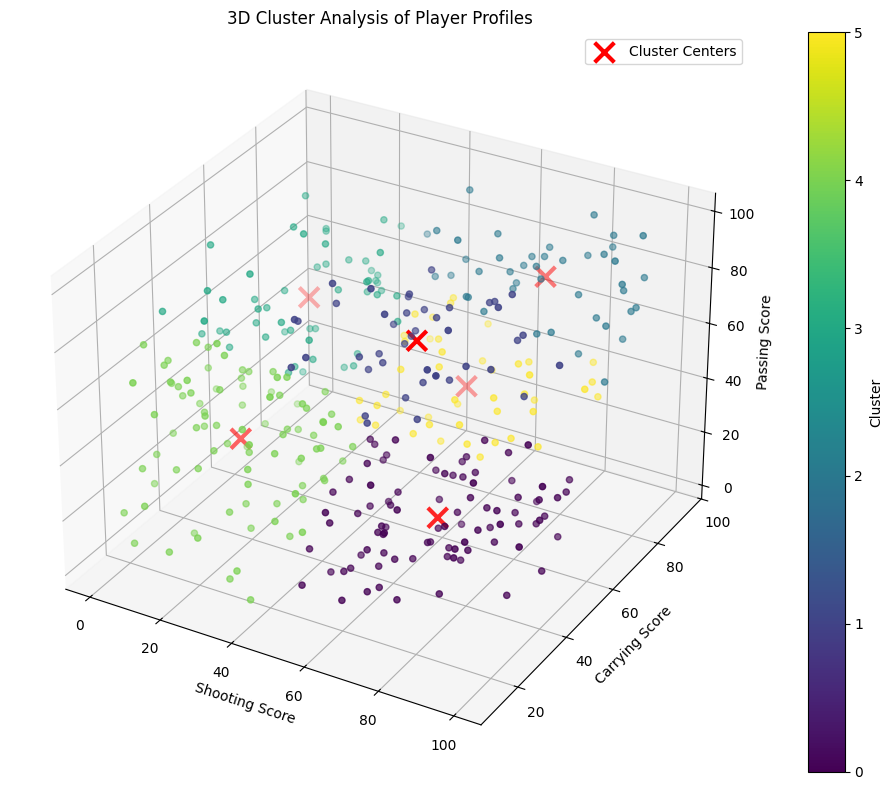


Cluster Analysis:
--------------------------------------------------------------------------------

Cluster 0 - Strong Shooting
Size: 88 players

Cluster Center Scores:
- Shooting: 72.49
- Carrying: 39.46
- Passing:  24.73

Example Players (closest to center):
- Patrick Cutrone (Como)
- Vedat Muriqi (Mallorca)
- Moritz Broschinski (Bochum)
- Álvaro Morata (Milan)
- Benjamin Šeško (RB Leipzig)
--------------------------------------------------------------------------------

Cluster 1 - Passing Specialist with Strong Shooting
Size: 42 players

Cluster Center Scores:
- Shooting: 60.34
- Carrying: 48.68
- Passing:  75.83

Example Players (closest to center):
- Iago Aspas (Celta Vigo)
- Franck Honorat (Gladbach)
- Takumi Minamino (Monaco)
- Andrej Kramarić (Hoffenheim)
- Álex Berenguer (Athletic Club)
--------------------------------------------------------------------------------

Cluster 2 - Triple Threat Forward
Size: 43 players

Cluster Center Scores:
- Shooting: 74.45
- Carrying: 80.0

In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Define features for clustering
features = ["shooting_score", "carrying_score", "passing_score"]
X = df_triple_threat[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create initial centers with one forced carrying specialist
initial_centers = np.zeros((6, 3))  # 8 clusters, 3 features
# Set the carrying specialist center (in scaled space)
#initial_centers[0] = [0, 2, 0]  # High carrying (2 std above mean), average others

# Initialize KMeans with our initialization
kmeans = KMeans(n_clusters=6, random_state=77, n_init=1, init=initial_centers)
kmeans.fit(X_scaled)
clusters = kmeans.labels_

# Add clusters to dataframe
df_clustered = df_triple_threat.copy()
df_clustered["cluster"] = clusters

# Get cluster centers in original scale
centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

# Profile analysis for each cluster
cluster_profiles = {}
for i in range(6):
    cluster_data = df_clustered[df_clustered['cluster'] == i]
    
    profile = {
        'center': dict(zip(features, centers_original[i])),
        'size': len(cluster_data),
        'players': cluster_data[['player', 'team'] + features].to_dict('records'),
        'avg_scores': {
            'shooting': cluster_data['shooting_score'].mean(),
            'carrying': cluster_data['carrying_score'].mean(),
            'passing': cluster_data['passing_score'].mean()
        }
    }
    
    # Get the center scores
    shooting = profile['center']['shooting_score']
    carrying = profile['center']['carrying_score']
    passing = profile['center']['passing_score']
    
    # Define thresholds for different skill levels
    triple_threat_threshold = 70 # Triple threat level
    specialist_threshold = 75  # Specialist level
    strong_threshold = 60      # Strong level
    capable_threshold = 50     # Capable level
    
    # Get highest attribute and its score (with rounding)
    scores = [('Shooting', round(shooting)), ('Carrying', round(carrying)), ('Passing', round(passing))]
    primary_attr, primary_score = max(scores, key=lambda x: x[1])
    
    # Check for Triple Threat Forward first using rounded scores
    if all(round(score[1]) > triple_threat_threshold for score in scores):
        profile['primary_attribute'] = "Triple Threat Forward"
    else:
        # Determine skill level based on thresholds with rounded scores
        if primary_score >= specialist_threshold:
            prefix = f"{primary_attr} Specialist"
        elif primary_score >= strong_threshold:
            prefix = f"Strong {primary_attr}"
        elif primary_score >= capable_threshold:
            prefix = f"Capable {primary_attr}"
        else:
            prefix = f"Bad Forwards"
            
        # Check for secondary attributes using rounded scores
        secondary_scores = [s for s in scores if s[0] != primary_attr and s[1] >= strong_threshold]
        if secondary_scores:
            secondary_attrs = [f"{s[0]}" for s in secondary_scores]
            profile['primary_attribute'] = f"{prefix} with Strong {' & '.join(secondary_attrs)}"
        else:
            profile['primary_attribute'] = prefix
    
    # Store the profile in cluster_profiles
    cluster_profiles[i] = profile

# Create visualization code
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_clustered['shooting_score'],
                    df_clustered['carrying_score'],
                    df_clustered['passing_score'],
                    c=clusters,
                    cmap='viridis')

ax.scatter(centers_original[:, 0],
          centers_original[:, 1],
          centers_original[:, 2],
          c='red',
          marker='x',
          s=200,
          linewidth=3,
          label='Cluster Centers')

ax.set_xlabel('Shooting Score')
ax.set_ylabel('Carrying Score')
ax.set_zlabel('Passing Score')
ax.set_title('3D Cluster Analysis of Player Profiles')

plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.tight_layout()
plt.show()

# Print cluster information
print("\nCluster Analysis:")
print("-" * 80)
for cluster_id, profile in cluster_profiles.items():
    print(f"\nCluster {cluster_id} - {profile['primary_attribute']}")
    print(f"Size: {profile['size']} players")
    print("\nCluster Center Scores:")
    print(f"- Shooting: {profile['center']['shooting_score']:.2f}")
    print(f"- Carrying: {profile['center']['carrying_score']:.2f}")
    print(f"- Passing:  {profile['center']['passing_score']:.2f}")
    
    print("\nExample Players (closest to center):")
    cluster_players = df_clustered[df_clustered['cluster'] == cluster_id]
    
    # Calculate distances and get top 5 closest players
    center = np.array([profile['center']['shooting_score'],
                      profile['center']['carrying_score'],
                      profile['center']['passing_score']])
    
    distances = []
    for idx, player in cluster_players.iterrows():
        point = np.array([player['shooting_score'],
                        player['carrying_score'],
                        player['passing_score']])
        distance = np.linalg.norm(point - center)
        distances.append((player['player'], player['team'], distance))
    
    distances.sort(key=lambda x: x[2])
    for player, team, dist in distances[:5]:
        print(f"- {player} ({team})")
    
    print("-" * 80)

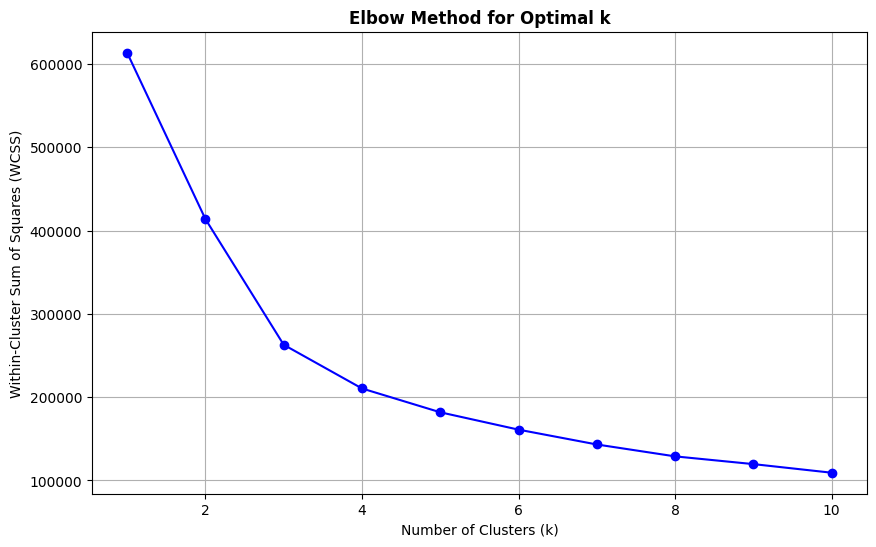

In [22]:
import matplotlib.pyplot as plt

def plot_elbow_method(data, max_k=10):
    wcss = []
    k_values = range(1, max_k + 1)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, wcss, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title('Elbow Method for Optimal k', fontdict={"weight":"bold"})
    plt.grid(True)
    return plt

plot = plot_elbow_method(X)
plot.show()

In [23]:
df_clustered["overall_score"] = df_clustered["shooting_score"] + df_clustered["carrying_score"] + df_clustered["passing_score"]

# To print all players from a specific cluster (e.g., cluster 2)
cluster_number = 5 # Change this to whichever cluster you want to see

# Get all players from the cluster with their scores
cluster_players = df_clustered[df_clustered['cluster'] == cluster_number].sort_values(
    by=["overall_score"], 
    ascending=False
)[['player', 'team', 'shooting_score', 'carrying_score', 'passing_score']]

print(f"\nAll Players in Cluster {cluster_number}:")
print("-" * 80)
print(cluster_players.to_string(index=False))


All Players in Cluster 5:
--------------------------------------------------------------------------------
             player           team shooting_score carrying_score passing_score
     Alexander Isak  Newcastle Utd      94.736842      65.434903     58.490305
    Abde Ezzalzouli          Betis      83.518006      87.432687      46.99446
        Ayoze Pérez     Villarreal       89.33518       77.58241     49.608726
 Alejandro Garnacho Manchester Utd      89.750693      79.620776     42.804709
     Dango Ouattara    Bournemouth      82.548476      61.238504     62.306094
     Evann Guessand           Nice      74.792244      68.635457      57.65928
     Mohammed Kudus       West Ham      72.437673      76.833241     51.204986
      Marcus Thuram          Inter       83.65651      61.337396     49.553324
     Mohamed Amoura      Wolfsburg      78.047091      66.341413     49.802632
      Malick Fofana           Lyon      48.891967      80.490028     63.220222
       Kaoru Mitoma    

In [24]:
for cluster in range(0,6):
    cluster_players = df_clustered[df_clustered['cluster'] == cluster].sort_values(
    by=["overall_score"], 
    ascending=False
    )[['player', 'team', 'shooting_score', 'carrying_score', 'passing_score']]

    print(f"\nAll Players in Cluster {cluster}:")
    print("-" * 80)
    print(cluster_players.head(5).to_string(index=False))


All Players in Cluster 0:
--------------------------------------------------------------------------------
              player            team shooting_score carrying_score passing_score
        Breel Embolo          Monaco      92.520776      45.440443     53.767313
         Deniz Undav       Stuttgart      99.861496      40.072022     46.305402
     Nicolas Jackson         Chelsea      94.252078      60.622438     29.605263
Valentín Castellanos           Lazio      96.814404      55.152632     30.671745
   Alexander Sørloth Atlético Madrid      97.783934      49.917175     33.365651

All Players in Cluster 1:
--------------------------------------------------------------------------------
            player            team shooting_score carrying_score passing_score
      Paulo Dybala            Roma      78.739612      59.321607     90.644044
        Harry Kane   Bayern Munich      95.706371      52.760665     77.091413
        Phil Foden Manchester City      78.947368      53.342

           player  cluster
326  Adama Traoré        2
343  Harry Wilson        1
158    Alex Iwobi        3
160  Raúl Jiménez        0


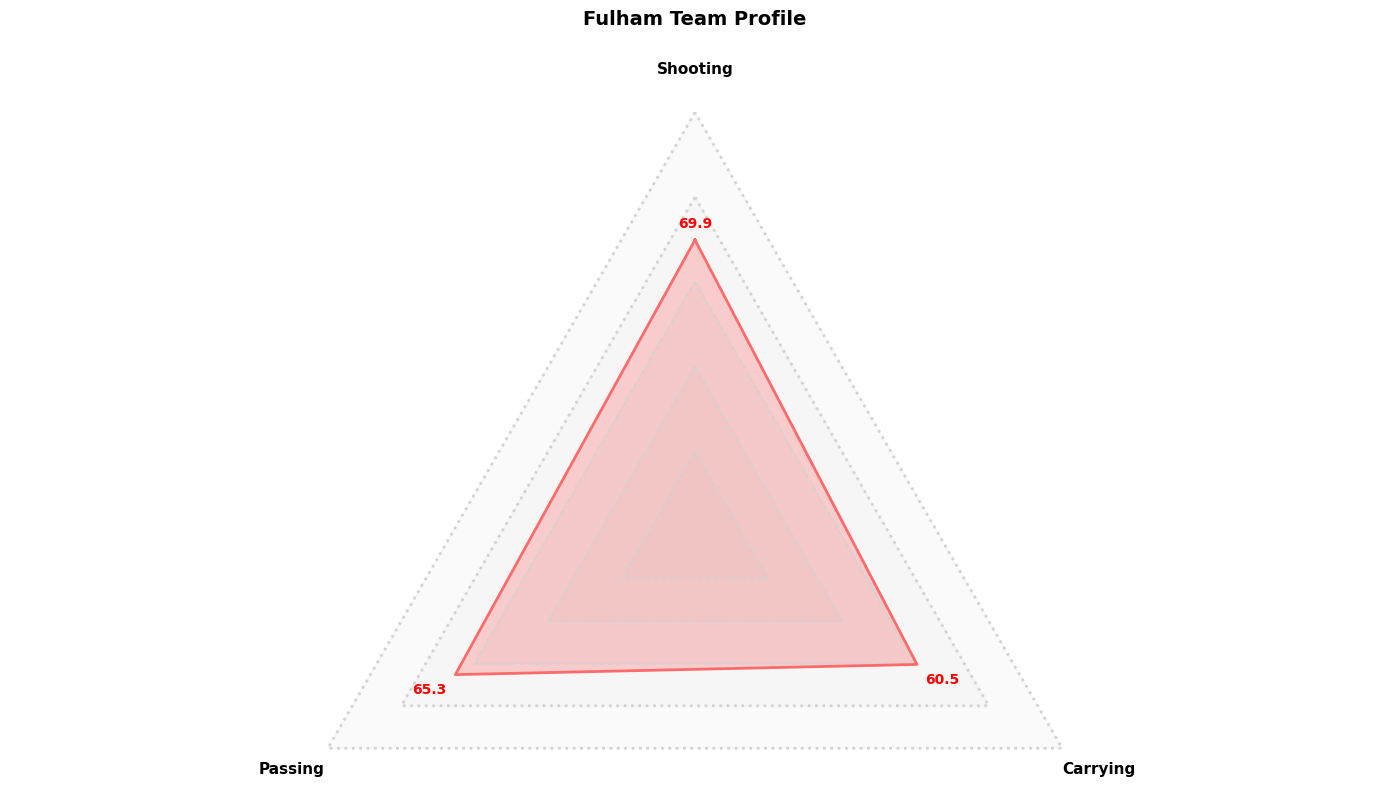

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Filter team data
team = "Fulham"
team_data = df_clustered[df_clustered['team'] == team]

print(team_data[["player", "cluster"]])

def create_triangle_radar(fig, values, color='red', alpha=0.1, linestyle='-'):
    angles = np.array([90, 210, 330])
    angles_rad = np.deg2rad(angles)
    x = values * np.cos(angles_rad)
    y = values * np.sin(angles_rad)
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    plt.plot(x, y, color=color, linewidth=2, linestyle=linestyle)
    plt.fill(x, y, color=color, alpha=alpha)
    
    # Return the coordinates for labeling
    return x[:-1], y[:-1]  # Return without the closing point

# Set style to light mode
plt.style.use('default')
fig = plt.figure(figsize=(14, 8), facecolor='white')
ax = fig.add_subplot(111)
ax.set_facecolor('white')

# Create the base triangle grid
grid_levels = [20, 40, 60, 80, 100]
for level in grid_levels:
    values = np.array([level, level, level])
    create_triangle_radar(fig, values, color='lightgray', alpha=0.1, linestyle=':')
    
    # # Add value label for shooting axis
    # if level < 100:
    #     plt.text(0, level * np.sin(np.deg2rad(90)), 
    #             str(level), 
    #             ha='right', 
    #             va='bottom',
    #             fontsize=8,
    #             color='gray')

# Calculate team average
team_avg = team_data[['shooting_score', 'passing_score', 'carrying_score']].mean()
values = np.array([
    team_avg['shooting_score'],
    team_avg['passing_score'],
    team_avg['carrying_score']
])
x_coords, y_coords = create_triangle_radar(fig, values, color='#FF6B6B', alpha=0.3)

# Add basic labels
label_distance = 110
angles = np.deg2rad([90, 210, 330])
labels = ['Shooting', 'Passing', 'Carrying']
label_x = label_distance * np.cos(angles)
label_y = label_distance * np.sin(angles)

for x, y, label in zip(label_x, label_y, labels):
    plt.text(x, y, label, ha='center', va='center', fontsize=11, fontweight='bold')

# Add value labels at triangle points
for i, (x, y, value) in enumerate(zip(x_coords, y_coords, values)):
    # Adjust position slightly outside the triangle point
    offset = 2
    if i == 0:  # Top point
        y_adj = y + offset
        ha = 'center'
        va = 'bottom'
    elif i == 1:  # Bottom left point
        x_adj = x - offset
        y_adj = y - offset
        ha = 'right'
        va = 'top'
    else:  # Bottom right point
        x_adj = x + offset
        y_adj = y - offset
        ha = 'left'
        va = 'top'
        
    plt.text(x_adj if i > 0 else x, 
            y_adj, 
            f'{value:.1f}', 
            ha=ha, 
            va=va,
            fontsize=10,
            fontweight='bold',
            color='red')

plt.title(f'{team} Team Profile', pad=40, fontsize=14, fontweight='bold')
plt.axis('equal')
ax.set_axis_off()
plt.tight_layout()
plt.show()